# Titanic competition

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
import plotly.graph_objects as go

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input
./kaggle/input\gender_submission.csv
./kaggle/input\test.csv
./kaggle/input\titanic.zip
./kaggle/input\train.csv


In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

df = pd.read_csv('./kaggle/input/train.csv')
train, test = train_test_split(df, test_size=0.25, random_state=0, shuffle=True, stratify=df.Survived,)
pd.DataFrame(train, columns=df.columns).to_csv('./kaggle/input/train_sampled.csv')
pd.DataFrame(test, columns=df.columns).to_csv('./kaggle/input/test_sampled.csv')
    
data: pd.DataFrame = pd.read_csv('./kaggle/input/train_sampled.csv').drop('PassengerId', axis=1)

numeric_cols = ['Age', 'Fare']
categorical_cols = data.columns.difference(numeric_cols)

data[categorical_cols] = data[categorical_cols].astype('category')

In [64]:
data[numeric_cols].describe()

,Age,Fare
count,532.000000,668.000000
mean,29.796842,33.273328
std,14.477953,53.472183
min,0.420000,0.000000
25%,20.000000,7.925000
50%,29.000000,14.454200
75%,38.000000,30.500000
max,80.000000,512.329200


In [65]:
data[categorical_cols].describe()

,Cabin,Embarked,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Unnamed: 0
count,153,666,668,668,668,668,668,668,668,668
unique,120,3,668,7,3,2,7,2,537,668
top,B96 B98,S,"Abbott, Mr. Rossmore Edward",0,3,male,0,0,347088,1
freq,3,487,1,513,366,433,462,412,6,1


<AxesSubplot:>

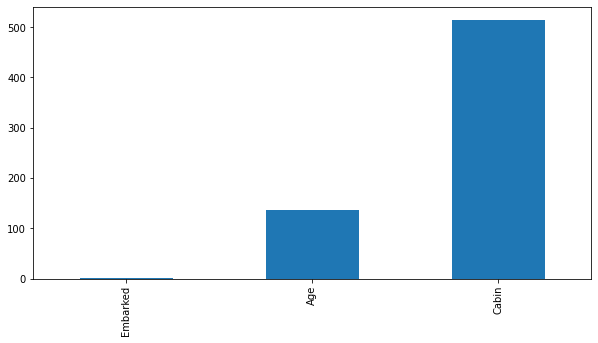

In [66]:
nans = data.isna().sum().sort_values()

plt.rcParams['figure.figsize'] = (10, 5)
nans.loc[nans > 0].plot.bar()

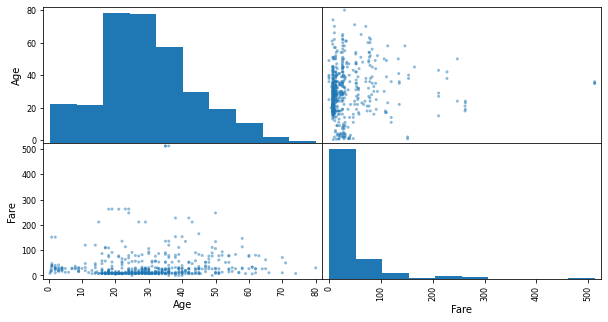

In [67]:
pd.plotting.scatter_matrix(data)
plt.show()

In [18]:
df_age_category = pd.merge(data, pd.cut(data['Age'], 15, precision = 0).dropna().rename('Age_category'), how='left', left_index =True, right_index=True) 

df_age_category.query('Sex == "male"')[['Age_category', 'Parch']].groupby('Age_category').agg(['unique']) # .plot.bar(x='Age_category', stacked=True)

,Parch
,unique
Age_category,
"(0.0, 6.0]","[1, 2]"
"(6.0, 11.0]","[1, 2, 0]"
"(11.0, 16.0]","[3, 0, 1, 2]"
"(16.0, 22.0]","[0, 2, 1]"
"(22.0, 27.0]","[0, 2, 1]"
"(27.0, 32.0]","[0, 2, 1]"
"(32.0, 38.0]","[0, 2, 1]"
"(38.0, 43.0]","[5, 0, 2, 1, 4]"


In [7]:
df_age_category.query('Sex == "female" and Parch in [3, 4]')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_category
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S,"(43.0, 48.0]"
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S,"(22.0, 27.0]"
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S,"(27.0, 32.0]"
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S,"(43.0, 48.0]"
774,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,"(53.0, 59.0]"
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C,"(22.0, 27.0]"


In [8]:
df_age_category.loc[df_age_category.Name.str.contains('Sidney')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_category
217,218,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,243847,27.00,NaN,S,"(38.0, 43.0]"
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.90,NaN,S,"(0.0, 6.0]"
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.75,NaN,S,"(22.0, 27.0]"
600,601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.00,NaN,S,"(22.0, 27.0]"


In [9]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [17]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=["didn't survive", "survived"], values=data.Survived.value_counts()),])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Rate of survival")
fig.show()


# simplest model possible

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

estimators = [
    (
        'categorical_cols', 
        ColumnTransformer(
            [(
                'ordinalEnc',
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
                categorical_cols.drop(['Name', 'Survived'])
                )]
        )
    ),
    ('imputer', SimpleImputer()),
    (
        'clf', LogisticRegression()
    )
]
pipe = Pipeline(estimators)

X = data.drop(['Survived', 'Name'], axis=1)
y = data.Survived

cross_val_score(pipe, X, y, scoring='f1')


c:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\gaetd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\gaetd\anaconda3\lib\site-packages

array([0.65934066, 0.73684211, 0.78095238, 0.72916667, 0.7032967 ])